## Importing dependencies

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from string import punctuation
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# nltk.download('all')

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


we have three useless column name `Unnamed:2`, `Unnamed:3` , `Unnamed:4`

In [3]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Now check for the null values

In [6]:
df.isna().sum()

v1    0
v2    0
dtype: int64

we don't have any null values in our dataset

Information about the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### Descriptive Statistics

In [8]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


#### Change the column names

In [9]:
df.columns = ['target', 'email']

In [10]:
df[df.target == 'ham'].duplicated().sum()

309

Check for Imbalance labels
- We only check imbalance for `target` columns

In [11]:
df['target'].value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

In [12]:
df[df.target == 'spam'].duplicated().sum()

94

## Check duplicate values

In [13]:
df.duplicated().sum()

403

**Insights**: we have total 403 duplicate observations
- Remove duplicate observation

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.target.value_counts()

target
ham     4516
spam     653
Name: count, dtype: int64

### Percentage of labels

In [16]:
values = df.target.value_counts()

total = values.sum()
values, total

(target
 ham     4516
 spam     653
 Name: count, dtype: int64,
 5169)

In [17]:
print(f"Ham %:- {(values['ham']/total) * 100}")
print(f"Spam %:- {(values['spam']/total) * 100}")

Ham %:- 87.3669955503966
Spam %:- 12.633004449603405


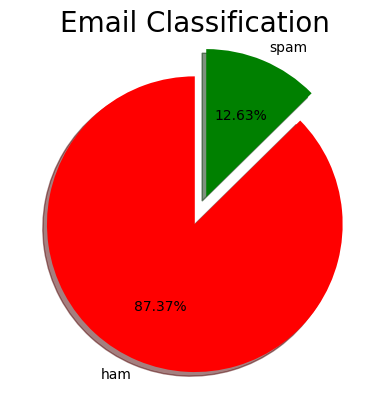

In [18]:
exp = [0, 0.2]
color = ['red', 'green']
plt.pie(values, explode=exp, shadow=True, labels=['ham', 'spam'], autopct="%0.2f%%", colors=color, startangle=90)
plt.title("Email Classification", size =20)
plt.show()

We can see that ham part is too high compare to spam message patterns

### Text length and structure analysis

In [19]:
df['char_len'] = df['email'].apply(len)
df['num_words'] = df['email'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sent'] = df['email'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [20]:
df.head()

,target,email,char_len,num_words,num_sent
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [21]:
df.columns

Index(['target', 'email', 'char_len', 'num_words', 'num_sent'], dtype='object')

In [22]:
df[['char_len', 'num_words', 'num_sent']].describe()

,char_len,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


### Summary descriptive stat for ham messages

In [23]:
df[df.target=='ham'][['char_len', 'num_words', 'num_sent']].describe()

,char_len,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


### Summary descriptive stat for spam messages

In [24]:
df[df.target=='spam'][['char_len', 'num_words', 'num_sent']].describe()

,char_len,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


### Distribution for charracter length spam messages

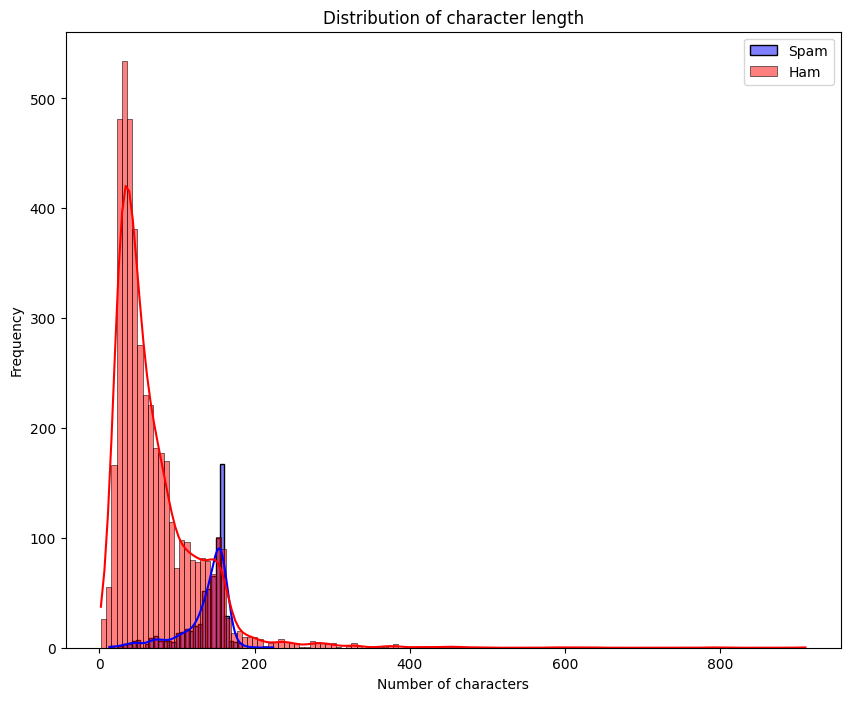

In [25]:
plt.figure(figsize=(10, 8))
sns.histplot(df[df.target=='spam']['char_len'], color='blue', kde=True, label='Spam')
sns.histplot(df[df.target=='ham']['char_len'], color='red', kde=True, label='Ham')
plt.title("Distribution of character length", fontweight=16)
plt.xlabel("Number of characters", fontsize = 10)
plt.ylabel("Frequency", fontsize=10)
plt.legend()
plt.show()

### Distribution of Number of words

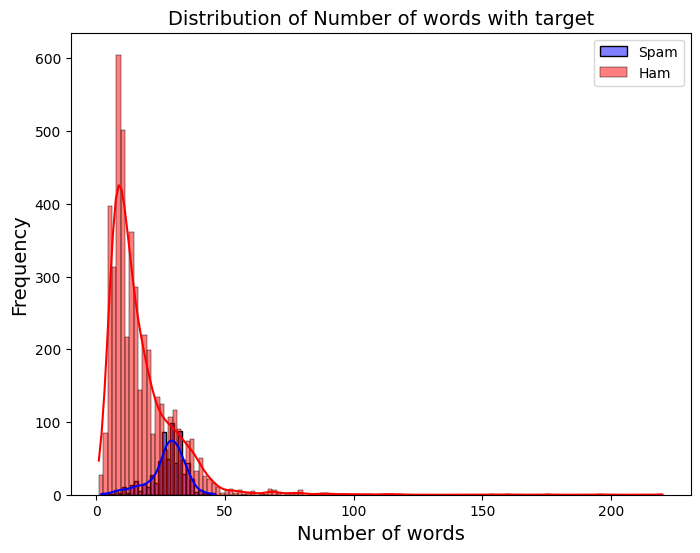

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(df[df.target=='spam']['num_words'], color='blue', kde=True, label='Spam')
sns.histplot(df[df.target=='ham']['num_words'], color='red', kde=True, label='Ham')
plt.title("Distribution of Number of words with target", fontweight=16, fontsize=14)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.show()

### DIstribution of Number of sentence wrt Target

In [27]:
df.columns

Index(['target', 'email', 'char_len', 'num_words', 'num_sent'], dtype='object')

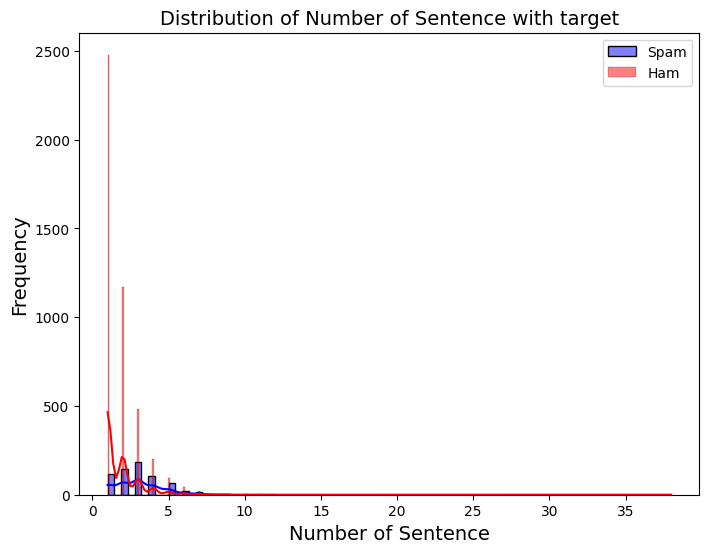

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(df[df.target=='spam']['num_sent'], color='blue', kde=True, label='Spam')
sns.histplot(df[df.target=='ham']['num_sent'], color='red', kde=True, label='Ham')
plt.title("Distribution of Number of Sentence with target", fontweight=16, fontsize=14)
plt.xlabel("Number of Sentence", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.show()

### Pairplot for this data

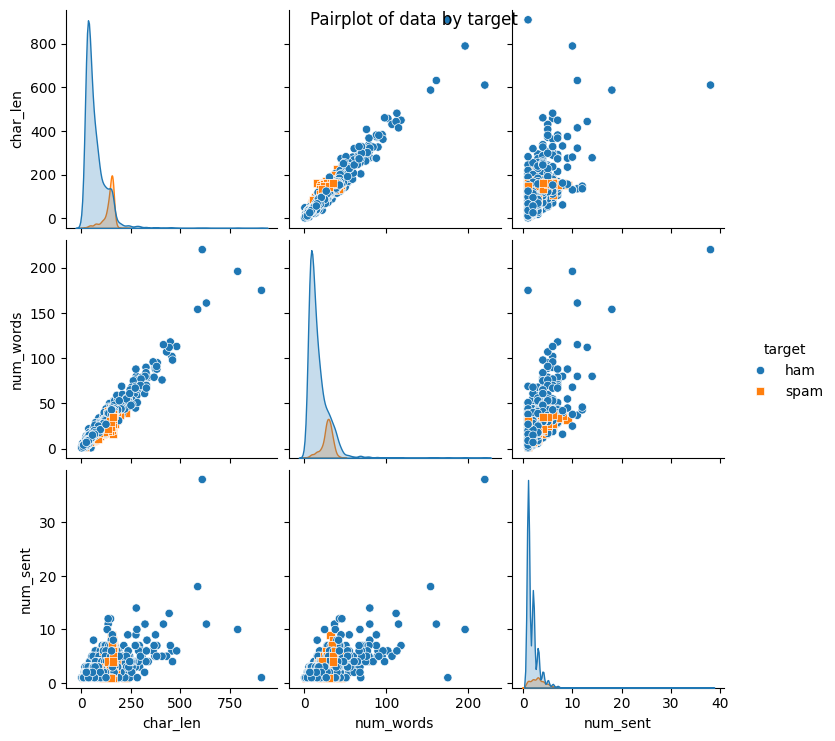

In [29]:
sns.pairplot(df, hue='target', diag_kind='kde', markers=['o', 's'])
plt.suptitle("Pairplot of data by target")
plt.show()

## Find the Correlation between variables

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.target = le.fit_transform(df['target'])

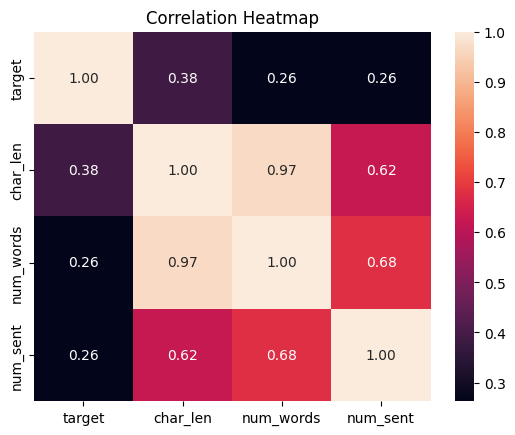

In [31]:
heat = df[['target', 'char_len', 'num_words', 'num_sent']].corr()
sns.heatmap(heat, fmt='0.2f', annot=True)
plt.title("Correlation Heatmap", fontweight=16)
plt.show()

## Data Preprocessing

In [32]:
text = df.iloc[8, 1]
text

'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

In [33]:
a = []
text.lower()
for  i in nltk.word_tokenize(text):
    if i.isalnum():
        a.append(i)

a

['WINNER',
 'As',
 'a',
 'valued',
 'network',
 'customer',
 'you',
 'have',
 'been',
 'selected',
 'to',
 'receivea',
 'prize',
 'reward',
 'To',
 'claim',
 'call',
 '09061701461',
 'Claim',
 'code',
 'KL341',
 'Valid',
 '12',
 'hours',
 'only']

In [34]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    ps = PorterStemmer()
    stop_words = stopwords.words('english')
    text = [ps.stem(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text

preprocess_text(df.iloc[8,1])

'winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour'

### Creating a column name Clean email

In [36]:
df['clean_email'] = df['email'].apply(preprocess_text)

In [37]:
df.head()

,target,email,char_len,num_words,num_sent,clean_email
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [38]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

## Wordcloud

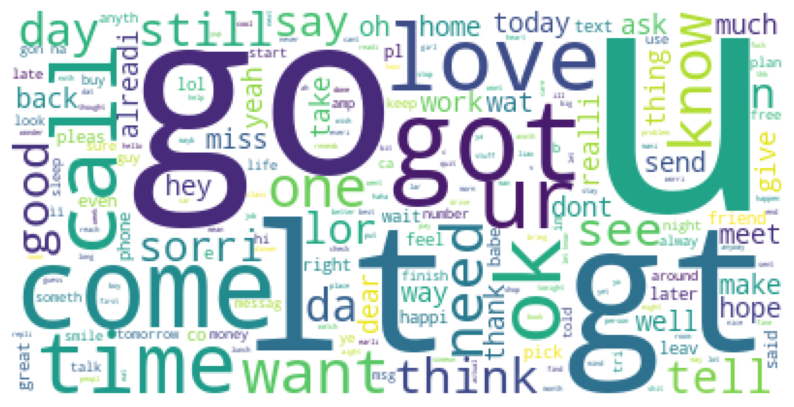

In [39]:
not_spam = df[df.target==0]['clean_email'].str.cat(sep=" ")

wordcloud = WordCloud(background_color='white').generate(not_spam)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

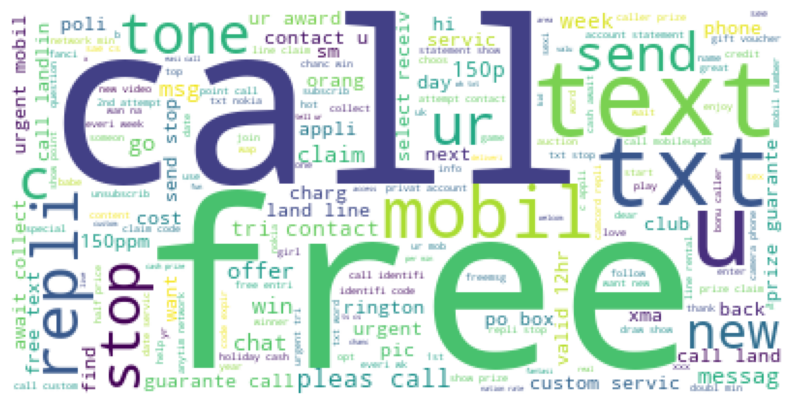

In [40]:
spam_series = df[df.target == 1]['clean_email'].str.cat(sep=" ")
plt.figure(figsize=(10, 8))
wordcloud = WordCloud(background_color='white').generate(spam_series)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
spam_series

'free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18 freemsg hey darl 3 week word back like fun still tb ok xxx std chg send rcv winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030 six chanc win cash 100 pound txt csh11 send cost 6day tsandc appli repli hl 4 info urgent 1 week free membership prize jackpot txt word claim 81010 c lccltd pobox 4403ldnw1a7rw18 xxxmobilemovieclub use credit click wap link next txt messag click http england v macedonia dont miss news txt ur nation team 87077 eg england 87077 tri wale scotland poboxox36504w45wq thank subscript rington uk mobil charg pleas confirm repli ye repli charg 07732584351 rodger burn msg tri call repli sm free nokia mobil free camcord pleas call 08000930705 deliveri tomorrow sm ac sptv new jersey devil detroit red w

## Find top 30 words of spam and not spam

In [42]:
spam = df[df.target == 1]['clean_email'].tolist()
spam_corpus = []
for email in spam:
    for word in email.split():
        spam_corpus.append(word)

spam_corpus[:10]

['free', 'entri', '2', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt']

In [43]:
from collections import Counter
most_frequent_spam_words = Counter(spam_corpus)
filter_spam_words = pd.DataFrame(most_frequent_spam_words.most_common(30), columns = ['words', 'frequency'])

In [44]:
filter_spam_words.head()

,words,frequency
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122


In [45]:
import warnings as wrn
wrn.filterwarnings('ignore')

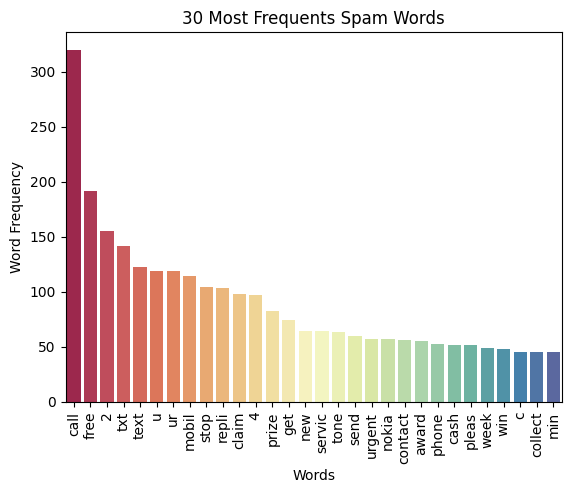

In [46]:
sns.barplot(data = filter_spam_words, x=filter_spam_words['words'], y = filter_spam_words['frequency'], palette='Spectral')
plt.xticks(rotation=90)
plt.title("30 Most Frequents Spam Words")
plt.ylabel("Word Frequency")
plt.xlabel("Words")
plt.savefig("topspam_words.png")
plt.show()

### Top 30 word of Ham

In [47]:
ham = df[df.target == 0]['clean_email'].tolist()
ham_corpus = []
for email in ham:
    for word in email.split():
        ham_corpus.append(word)

ham_corpus[:10]

['go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi',
 'n',
 'great',
 'world',
 'la']

In [48]:
filter_ham_words = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['words', 'frequency'])
filter_ham_words.head()

,words,frequency
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287


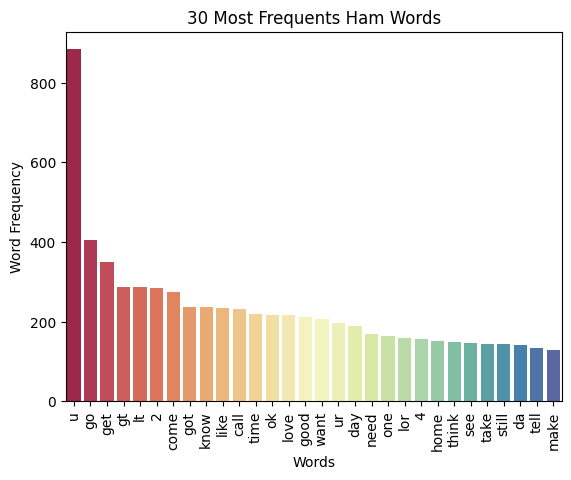

In [49]:
sns.barplot(data=filter_ham_words, x = filter_ham_words['words'], y = filter_ham_words['frequency'], palette='Spectral')
plt.xticks(rotation=90)
plt.title("30 Most Frequents Ham Words")
plt.ylabel("Word Frequency")
plt.xlabel("Words")
plt.savefig('topham_words.png')
plt.show()

## Model Building
- Dependent and Independent Variables
- Vector Embedding using Term-Frequency Inverse Document Frequency
- Spliting the Data into training and testing set
- Sampling Technique
- Training the Model

### Dependent and Independent Variables

In [50]:
X, y = df['clean_email'], df['target']

### Vector Embedding using Term-Frequency Inverse Document Frequency

In [51]:
tfidf = TfidfVectorizer()
tfidf.fit(X)
X_tfidf = tfidf.transform(X)

In [52]:
X_tfidf.shape

(5169, 6708)

In [53]:
X_tfidf[0]

<1x6708 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [54]:
features_name = pd.DataFrame(tfidf.get_feature_names_out())
features_name

,0
0,008704050406
1,0089
2,0121
3,01223585236
4,01223585334
...,...
6703,åòit
6704,åômorrow
6705,åôrent
6706,ìä


In [55]:
features_name.shape

(6708, 1)

### Spliting the Data into training and testing set

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3876, 6708), (1293, 6708), (3876,), (1293,))

### SMOTE technique to balance over sampling

In [58]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Training the model

In [59]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [60]:
svc = SVC(kernel='sigmoid')
lrc = LogisticRegression(solver='liblinear', penalty='l1')
bn = BernoulliNB()
gn = GaussianNB()
mn = MultinomialNB()
rfc = RandomForestClassifier(n_jobs=-1)
abc = AdaBoostClassifier()
bc = BaggingClassifier(n_jobs=-1)
etc = ExtraTreesClassifier(n_jobs=-1)
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_jobs=-1)

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [62]:
classifier = {
    "SVC":svc, 
    "Logistic": lrc,
    "Bernoulli" : bn, 
    "Multinomial": mn,
    "RandomForest": rfc, 
    "AdaBoost": abc, 
    "Bagging": bc,
    "ExtraTree":etc,
    "DecisionTree":dtc,
    "KNN": knn}

def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    confusion = confusion_matrix(y_pred, y_test)
    return accuracy, precision, confusion

In [63]:
results = {}
results['name'] = []
results['accuracy'] = []
results['precision'] = []
results['confusion matrix'] = []

for name, clf in classifier.items():
    accuracy, precision, conusion = train_classifier(clf, X_train_res, y_train_res, X_test, y_test)
    print("For :-\t",name)
    print("Accuracy :-\t", round(accuracy, 4))
    print('Precision :-\t', round(precision, 4))
    print("Confusion Matrix:-\t", conusion)
    print()
    results['name'].append(name)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['confusion matrix'].append(conusion)

For :-	 SVC
Accuracy :-	 0.976
Precision :-	 0.8837
Confusion Matrix:-	 [[1110   20]
 [  11  152]]

For :-	 Logistic
Accuracy :-	 0.9698
Precision :-	 0.8605
Confusion Matrix:-	 [[1106   24]
 [  15  148]]

For :-	 Bernoulli
Accuracy :-	 0.9776
Precision :-	 0.8314
Confusion Matrix:-	 [[1121   29]
 [   0  143]]

For :-	 Multinomial
Accuracy :-	 0.9675
Precision :-	 0.9302
Confusion Matrix:-	 [[1091   12]
 [  30  160]]

For :-	 RandomForest
Accuracy :-	 0.9799
Precision :-	 0.8547
Confusion Matrix:-	 [[1120   25]
 [   1  147]]

For :-	 AdaBoost
Accuracy :-	 0.9637
Precision :-	 0.843
Confusion Matrix:-	 [[1101   27]
 [  20  145]]

For :-	 Bagging
Accuracy :-	 0.9474
Precision :-	 0.8663
Confusion Matrix:-	 [[1076   23]
 [  45  149]]

For :-	 ExtraTree
Accuracy :-	 0.9814
Precision :-	 0.8721
Confusion Matrix:-	 [[1119   22]
 [   2  150]]

For :-	 DecisionTree
Accuracy :-	 0.9428
Precision :-	 0.8721
Confusion Matrix:-	 [[1069   22]
 [  52  150]]

For :-	 KNN
Accuracy :-	 0.942
Precision 

In [64]:
results_df = pd.DataFrame(results, columns=['name', 'accuracy', 'precision', 'confusion matrix'])

In [65]:
results_df.to_csv('results.csv')

## Compare the Accuracy and Precision

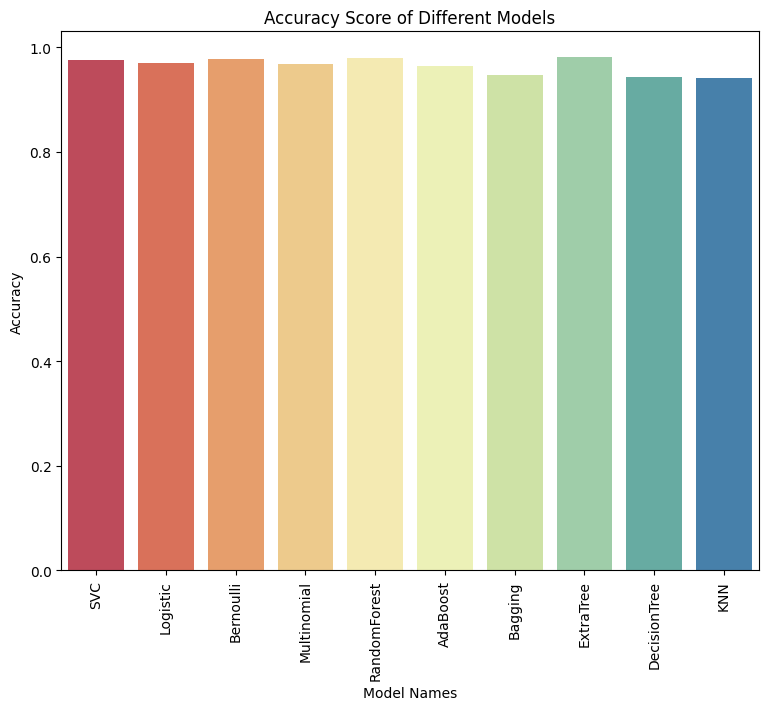

In [66]:
plt.figure(figsize=(9, 7))
sns.barplot(data=results_df, x=results_df['name'], y=results_df['accuracy'], palette='Spectral')
plt.xticks(rotation=90)
plt.title("Accuracy Score of Different Models")
plt.xlabel("Model Names")
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')
plt.show()

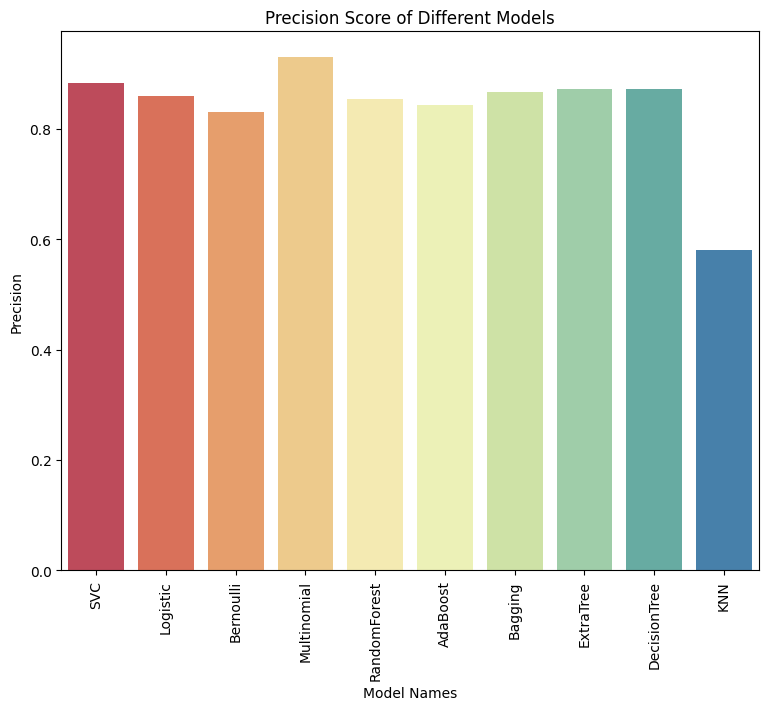

In [67]:
plt.figure(figsize=(9,7))
sns.barplot(data=results_df, x=results_df['name'], y=results_df['precision'], palette='Spectral')
plt.xticks(rotation=90)
plt.title("Precision Score of Different Models")
plt.xlabel("Model Names")
plt.ylabel('Precision', fontweight=100)
plt.savefig('precision.png')
plt.show()

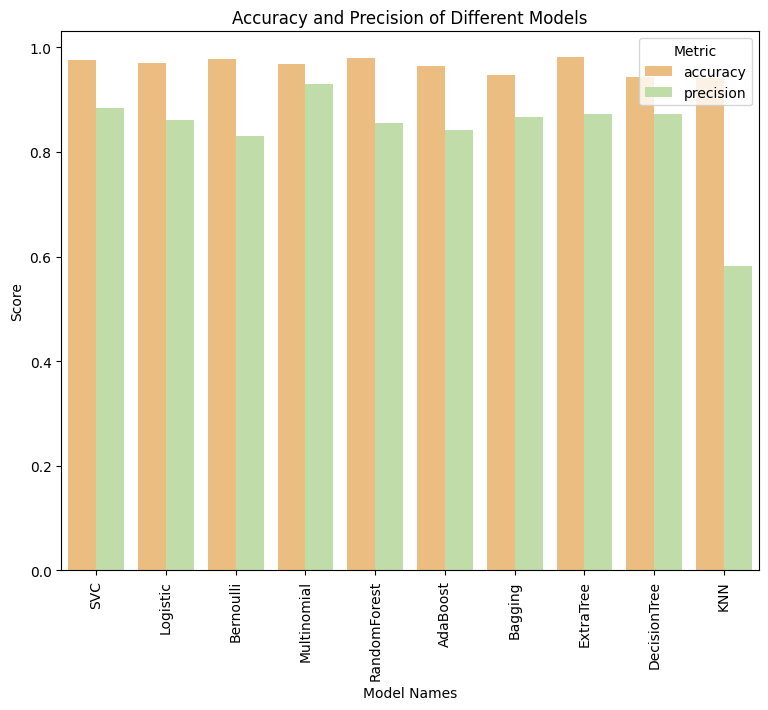

In [68]:

# Assuming results is a DataFrame with 'name', 'accuracy', and 'precision' columns
results_melted = pd.melt(results_df, id_vars='name', value_vars=['accuracy', 'precision'], var_name='Metric', value_name='Value')

plt.figure(figsize=(9, 7))
sns.barplot(data=results_melted, x='name', y='Value', hue='Metric', palette='Spectral')
plt.xticks(rotation=90)
plt.xlabel("Model Names")
plt.ylabel('Score')
plt.title('Accuracy and Precision of Different Models')
plt.legend(title='Metric')
plt.savefig('accuracy_precision.png')
plt.show()

In [69]:
np.arange(len(results))

array([0, 1, 2, 3])

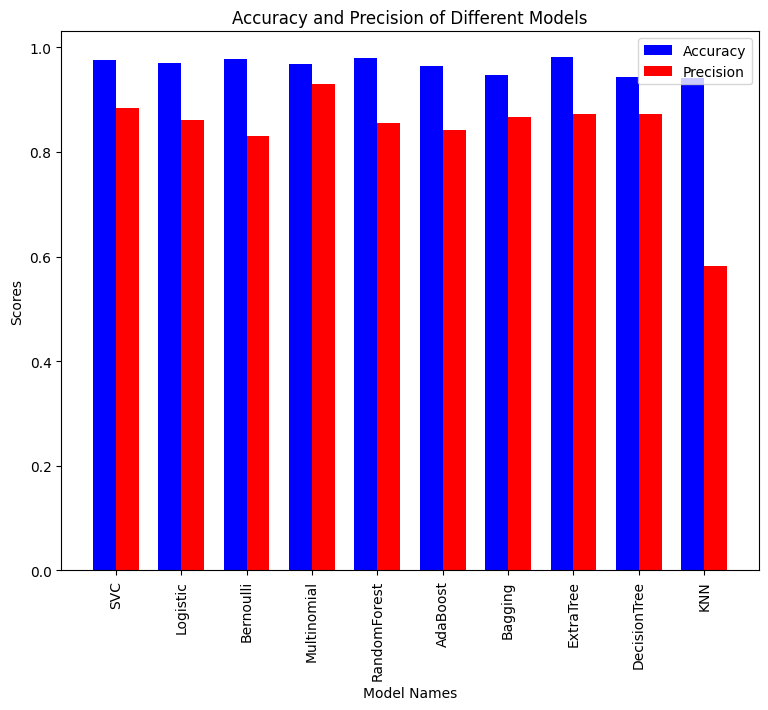

In [70]:
# Define the bar width and the positions of the bars
bar_width = 0.35
index = np.arange(len(results_df))

plt.figure(figsize=(9, 7))

# Plot the bars
bars1 = plt.bar(index, results_df['accuracy'], bar_width, label='Accuracy', color='b')
bars2 = plt.bar(index + bar_width, results_df['precision'], bar_width, label='Precision', color='r')

# Add labels, title, and custom x-axis tick labels, etc.
plt.xlabel('Model Names')
plt.ylabel('Scores')
plt.title('Accuracy and Precision of Different Models')
plt.xticks(index + bar_width / 2, results_df['name'], rotation=90)
plt.legend()
# Save the plot
plt.savefig('accuracy_precision1.png')

# Show the plot
plt.show()


In [71]:
accuracy = results_df['accuracy'].tolist()
precision = results_df['precision'].tolist()
names  = results_df['name'].tolist()

In [72]:
name

'KNN'

In [73]:
results_df

,name,accuracy,precision,confusion matrix
0,SVC,0.976025,0.883721,"[[1110, 20], [11, 152]]"
1,Logistic,0.969838,0.860465,"[[1106, 24], [15, 148]]"
2,Bernoulli,0.977572,0.831395,"[[1121, 29], [0, 143]]"
3,Multinomial,0.967517,0.930233,"[[1091, 12], [30, 160]]"
4,RandomForest,0.979892,0.854651,"[[1120, 25], [1, 147]]"
5,AdaBoost,0.963650,0.843023,"[[1101, 27], [20, 145]]"
6,Bagging,0.947409,0.866279,"[[1076, 23], [45, 149]]"
7,ExtraTree,0.981439,0.872093,"[[1119, 22], [2, 150]]"
8,DecisionTree,0.942769,0.872093,"[[1069, 22], [52, 150]]"
9,KNN,0.941995,0.581395,"[[1118, 72], [3, 100]]"


In [74]:
diff = {}
for name, ac, pre in zip(names, accuracy, precision):
    diff[name] = round(ac - pre, 4)

In [75]:
for name, value in diff.items():
    print(f"{name} :- {value}")

SVC :- 0.0923
Logistic :- 0.1094
Bernoulli :- 0.1462
Multinomial :- 0.0373
RandomForest :- 0.1252
AdaBoost :- 0.1206
Bagging :- 0.0811
ExtraTree :- 0.1093
DecisionTree :- 0.0707
KNN :- 0.3606


### Let's try for Gaussian Model

In [76]:
gn.fit(X_train_res.toarray(), y_train_res)

GaussianNB()

In [77]:
y_pred = gn.predict(X_test.toarray())
ac = accuracy_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)
prec = precision_score(y_pred, y_test)

In [103]:
ac, prec

(0.979891724671307, 0.8604651162790697)

In [78]:
results_df.columns

Index(['name', 'accuracy', 'precision', 'confusion matrix'], dtype='object')

In [79]:
gaussian = {'name': 'Gaussian', 'accuracy': ac, "precision":prec, 'confusion matrix': con}
gaussian

{'name': 'Gaussian',
 'accuracy': 0.8839907192575406,
 'precision': 0.8604651162790697,
 'confusion matrix': array([[995,  24],
        [126, 148]], dtype=int64)}

In [108]:
results_df.loc[len(results_df.index)] = ['Gaussian', ac, prec, con]
results_df.to_csv('results.csv')

<Axes: >

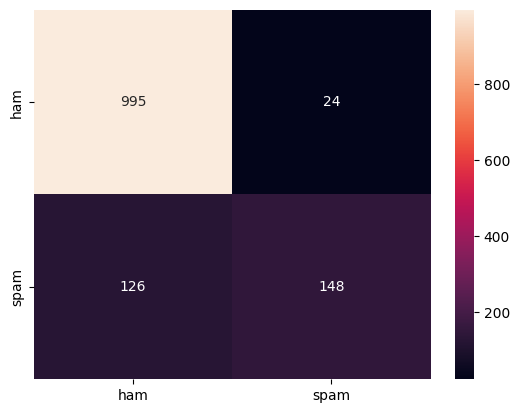

In [81]:
sns.heatmap(con, annot=True, fmt= 'd', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])

## Heatmap of Different Models

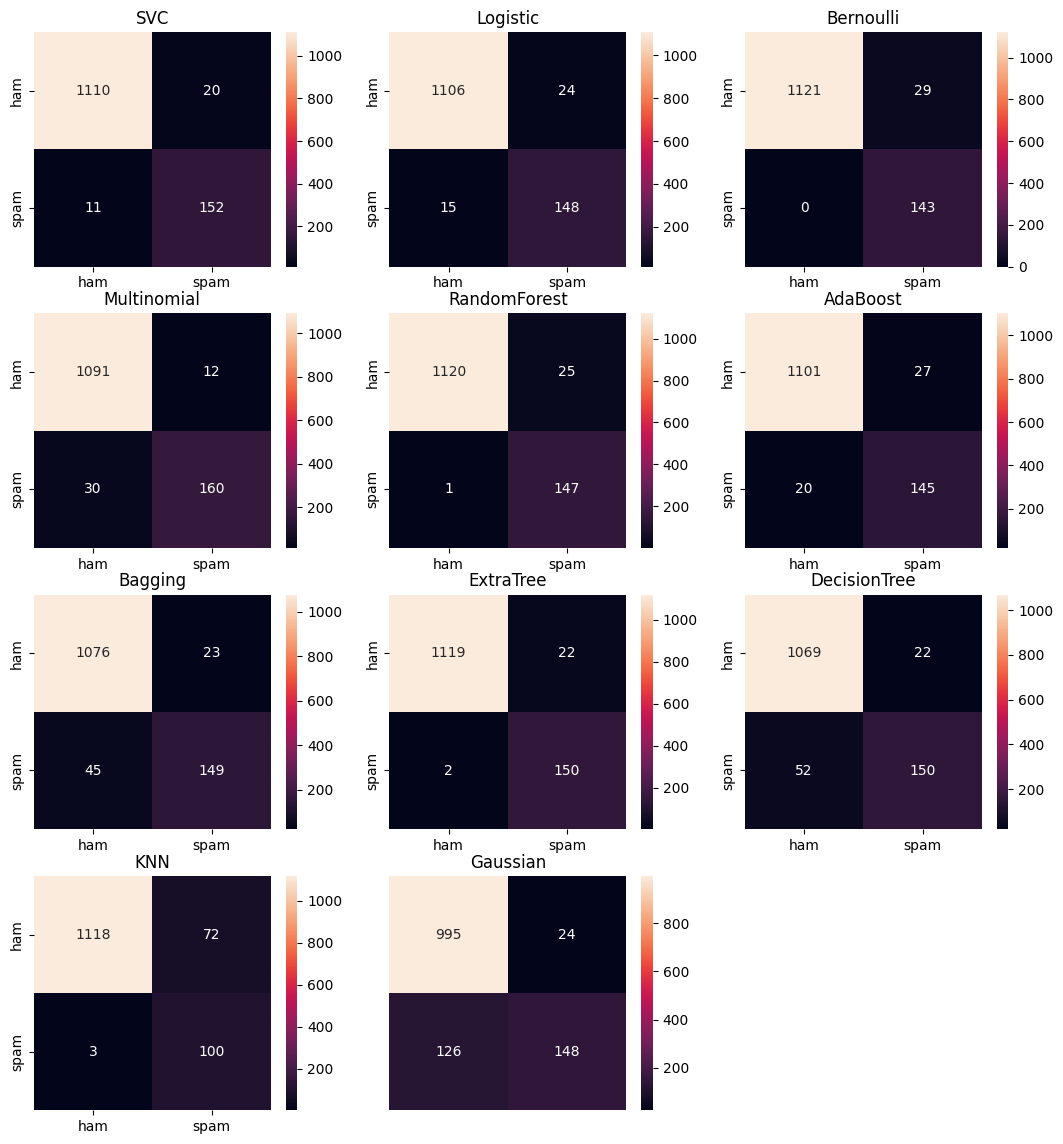

In [82]:
names = results_df['name'].tolist()
metrices = results_df['confusion matrix'].tolist()
i = 0
label = ['ham', 'spam']
plt.figure(figsize=(13, 14))
for name, metrice in zip(names, metrices):
    plt.subplot(4, 3, i+1)
    sns.heatmap(metrice, annot=True, fmt="d", xticklabels=label, yticklabels=label)
    plt.title(name)
    i += 1
plt.axis('off')
plt.savefig('confusion_matrix.png')
plt.show() 

**Insights:** I would prefer ExtraTree Classifier Model

In [83]:
best_model = min(diff, key=diff.get)

In [84]:
best_model

'Multinomial'

### Multinomial Naive Bayes

In [85]:
mn = MultinomialNB()
mn.fit(X_train_res, y_train_res)

MultinomialNB()

In [86]:
y_pred = mn.predict(X_test)
ac = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)

In [87]:
ac, pre

(0.9675174013921114, 0.9302325581395349)

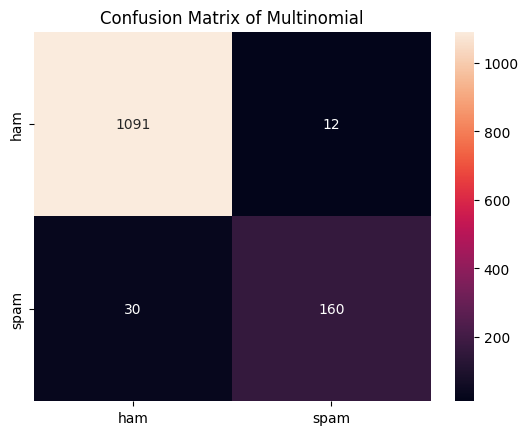

In [88]:
label = ['ham', 'spam']
sns.heatmap(con, annot=True, fmt='d', xticklabels=label, yticklabels=label)
plt.title("Confusion Matrix of Multinomial")
plt.savefig("confusion_multinomial.png")
plt.show()

In [89]:
import joblib
joblib.dump(mn, 'optimal_spam_email_mn_96.7.joblib')

['optimal_spam_email_mn_96.7.joblib']

### Bernoulli Naive Bayes

In [90]:
bn.fit(X_train_res, y_train_res)
y_pred = bn.predict(X_test)
ac = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)

In [91]:
ac

0.9775715390564579

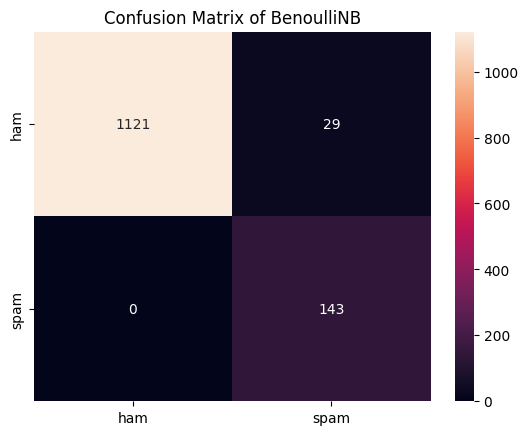

In [92]:
label = ['ham', 'spam']
sns.heatmap(con, annot=True, fmt='d', xticklabels=label, yticklabels=label)
plt.title("Confusion Matrix of BenoulliNB")
plt.savefig("confusion_matrix_bernoulli.png")
plt.show()

In [93]:
import joblib
joblib.dump(bn, 'best_spam_email_bn_97.7.joblib')

['best_spam_email_bn_97.7.joblib']

## Support Vector Machine

In [94]:
svc.fit(X_train_res, y_train_res)
y_pred = svc.predict(X_test)
ac = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)

In [95]:
ac

0.9760247486465584

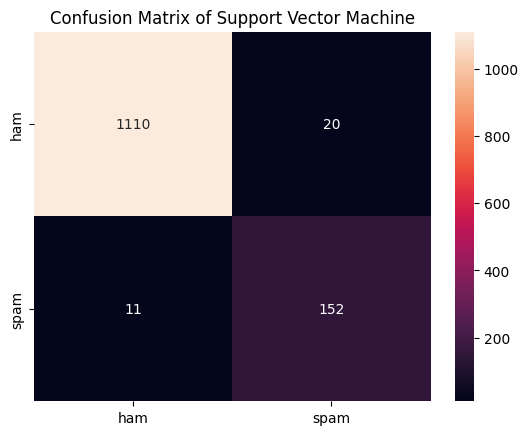

In [96]:
label = ['ham', 'spam']
sns.heatmap(con, annot=True, fmt='d', xticklabels=label, yticklabels=label)
plt.title("Confusion Matrix of Support Vector Machine")
plt.savefig("confusion_matrix_svc.png")
plt.show()

In [97]:
import joblib
joblib.dump(svc, 'best_spam_email_svc_97.6.joblib')

['best_spam_email_svc_97.6.joblib']

### Extra Tree Classifier

In [98]:
etc.fit(X_train_res, y_train_res)
y_pred = etc.predict(X_test)
ac = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)

In [99]:
ac, pre

(0.979891724671307, 0.872093023255814)

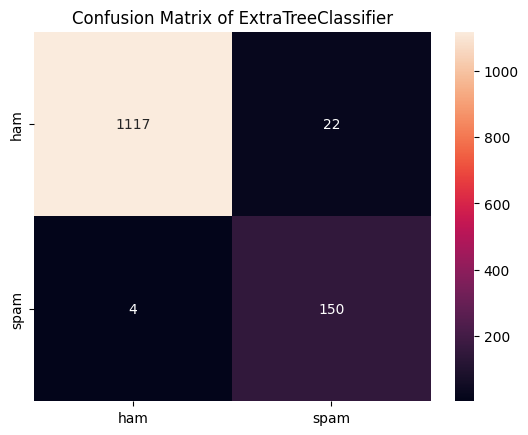

In [100]:
label = ['ham', 'spam']
sns.heatmap(con, annot=True, fmt='d', xticklabels=label, yticklabels=label)
plt.title("Confusion Matrix of ExtraTreeClassifier")
plt.savefig("confusion_extratreeclassifier.png")
plt.show()

In [101]:
import joblib
joblib.dump(etc, 'best_spam_email_extratree_98.joblib')

['best_spam_email_extratree_98.joblib']

### Testing

In [104]:
xg = XGBClassifier()
xg.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [109]:
y_pred = xg.predict(X_test)
ac = accuracy_score(y_pred, y_test)
pre = precision_score(y_pred, y_test)
con = confusion_matrix(y_pred, y_test)
ac, pre

(0.9706109822119103, 0.8837209302325582)

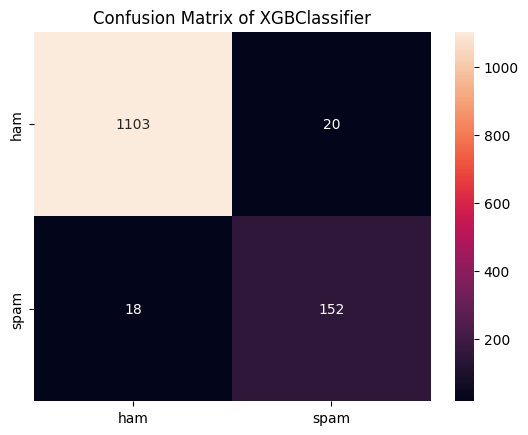

In [110]:
label = ['ham', 'spam']
sns.heatmap(con, annot=True, fmt='d', xticklabels=label, yticklabels=label)
plt.title("Confusion Matrix of XGBClassifier")
plt.savefig("confusion_xgbclassifier.png")
plt.show()

In [111]:
results_df.head()

,name,accuracy,precision,confusion matrix
0,SVC,0.976025,0.883721,"[[1110, 20], [11, 152]]"
1,Logistic,0.969838,0.860465,"[[1106, 24], [15, 148]]"
2,Bernoulli,0.977572,0.831395,"[[1121, 29], [0, 143]]"
3,Multinomial,0.967517,0.930233,"[[1091, 12], [30, 160]]"
4,RandomForest,0.979892,0.854651,"[[1120, 25], [1, 147]]"


In [112]:
results_df.loc[len(results_df.index)] = ['XGBoost', ac, pre, con]
results_df.to_csv('results.csv')

In [ ]:
df.iloc[100, 1], df.iloc[100, 0]

In [ ]:
le.inverse_transform(xg.predict(tfidf.transform([df.iloc[100, 1]])))

In [ ]:
df.iloc[2, 1], df.iloc[2, 0]

## Save the Vectorizer label encoder and best models

In [ ]:
joblib.dump(tfidf, 'tfidf.joblib')
joblib.dump(le, 'label_encoder.joblib')

# Conclusion
- Extra Tree Classifier demonstrated the highest accuracy
- Support Vector Machine and Bernoulli demonstrated the second highest
- But after comparing the precision and accuracy of Multinomial I think it is the best